In [1]:
from datagen import *
#from train import *
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear, BatchNorm1d
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        self.preprocess=args.preprocess
        self.bn = args.bn
        
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        if self.preprocess:
            self.pre_mp = nn.Sequential(nn.Linear(input_dim,self.preprocess))
            self.input_dim = self.preprocess
        else:
            self.input_dim = input_dim
        if self.bn:
            self.bns = nn.ModuleList([BatchNorm1d(input_dim)])
        if args.model_type=='GraphSage':
            self.convs.append(conv_model(self.input_dim, hidden_dim))
            if self.bn:
                self.bns.append(BatchNorm1d(hidden_dim))
        elif args.model_type=='GAT':     
            self.convs.append(conv_model(self.input_dim, hidden_dim, args.heads))
            if self.bn:
                self.bns.append(BatchNorm1d(args.heads *hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            if args.model_type=='GraphSage':
                self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))
                if self.bn:
                    self.bns.append(BatchNorm1d(hidden_dim))
            elif args.model_type=='GAT':    
                self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim, args.heads))
                if self.bn:
                    self.bns.append(BatchNorm1d(args.heads * hidden_dim))
                    
        # post-message-passing
        self.post_mp = nn.Sequential(nn.Linear(args.heads * hidden_dim, output_dim))
#         nn.Sequential(
#             nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
#             nn.Linear(hidden_dim, output_dim))
#         if self.bn:
#             self.bns.append(BatchNorm1d(output_dim))
        
        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
#         print(x.shape, edge_index.shape, batch.shape)  
#         print('batch',batch)
        if self.bn:
            x = self.bns[0](x)
        if self.preprocess:
            x = self.pre_mp(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.bn:
                x = self.bns[i+1](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)
#         if self.bn: #somehow this bn makes it worse
#             x = self.bns[-1](x) 
            
        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)
    

In [3]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = Linear(self.in_channels,self.out_channels, bias=bias)
        self.lin_r = Linear(self.in_channels,self.out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""
#         print('x',x.shape,'edge idx', edge_index.shape)
#         print('(x,x)')
        x_agg = self.propagate(edge_index, size=size, x=(x,x))
#         print('x_agg at graphsage forward', x_agg.shape, type(x_agg))
#         print('lin_r',self.lin_r(x_agg).shape)
#         print('lin_l', self.lin_l(x).shape)
        out = self.lin_l(x)+self.lin_r(x_agg)
#         print('out', out.shape)
        if self.normalize:
            out = torch.nn.functional.normalize(out) 

        return out

    def message(self, x_j):
        out = x_j

        return out

    def aggregate(self, inputs, index, dim_size = None):
        node_dim = self.node_dim
        out =  torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean') 
        return out

In [4]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads,
                 negative_slope = 0.2, dropout = 0.,**kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = Linear(self.in_channels, self.heads*self.out_channels,bias=False)
        self.lin_r = self.lin_l

        self.att_l = Parameter(torch.Tensor(1,self.heads,self.out_channels))
        self.att_r = Parameter(torch.Tensor(1,self.heads,self.out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels
        x_l = self.lin_l(x).view(-1,H,C)
        x_r = self.lin_r(x).view(-1,H,C)
        alpha_l=(self.att_l*x_l).sum(dim=-1)
        alpha_r=(self.att_r*x_r).sum(dim=-1)
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.view(-1, self.heads * self.out_channels)

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        alpha = alpha_i+alpha_j
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        out = x_j * alpha.unsqueeze(-1)

        return out


    def aggregate(self, inputs, index, dim_size = None):

        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='mean')
   
        return out

In [5]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [6]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt



def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True) #why test acc fluctuates more if train data is shiffled?
    test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False) 

    # build model
    
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ### GPU
    device = torch.device("cuda:0")
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args).to(device) ### GPU
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    train_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()

        for batch in loader:
#             print('batch',batch.x.shape, batch.y.shape, batch.train_mask.sum(), batch.val_mask.sum(), batch.test_mask.sum())
            batch = batch.to(device) ### GPU
            opt.zero_grad()
            model = model.to(device)
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            train_acc, test_acc = test(test_loader, model)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = copy.deepcopy(model)
        else:
            test_accs.append(test_accs[-1])
            train_accs.append(train_accs[-1])
    
    return train_accs, test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    #device =  torch.device('cpu')
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ### GPU
    device = torch.device("cuda:1")
    test_model = test_model.to(device)
    #test_model = test_model.to(device)
    test_model.eval()
    correct_tr = 0
    correct_te = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y
        pred_tr = pred[data.train_mask]
        label_tr = label[data.train_mask]
        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
            print("Saving Model Predictions for Model Type", model_type)
            data_tr = {}
            data_te = {}
            data_tr['pred'] = pred_tr.view(-1).cpu().detach().numpy()
            data_tr['label'] = label_tr.view(-1).cpu().detach().numpy()
            data_te['pred'] = pred.view(-1).cpu().detach().numpy()
            data_te['label'] = label.view(-1).cpu().detach().numpy()

            df_tr = pd.DataFrame(data=data_tr)
            df_te = pd.DataFrame(data=data_te)
          # Save locally as csv
            df_tr.to_csv('Cancer-Node-' + model_type + '_train.csv', sep=',', index=False)
            df_te.to_csv('Cancer-Node-' + model_type + '_test.csv', sep=',', index=False)
        
        correct_tr += pred_tr.eq(label_tr).sum().item()    
        correct_te += pred.eq(label).sum().item()
    
    total_tr = 0
    total_te = 0
    for data in loader.dataset:
        total_tr += torch.sum(data.train_mask).item()
        total_te += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct_tr / total_tr, correct_te / total_te
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [7]:
datadir = 'data/torchdata'
## To do: add load function for pre-saved data

cancertype = 'breast' #ovarian, breast, lung, prostate, colon, pancreatic

for dataargs in [{'cancertype':cancertype, 'datadir':datadir, 'test_size':0.3, 'validation':True},]:
    dataargs = objectview(dataargs)   



Create the breast cancer dataset
Cancer Type: breast cancer
PPI subnetwork: 7058 nodes, 188045 edges.
edges (2, 376090) , edge weights (376090,)
labels (7058,)
4031


/home/geena/project/ovacan/datagen.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHsub['tar_idx'] = RHsub['tarEz'].apply(lambda x: id2idx[x])
/home/geena/project/ovacan/datagen.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHsub['nc_idx'] =  RHsub['ncEz'].apply(lambda x: id2fidx[x])
/opt/anaconda3/envs/gnn/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


node feature matrix: (7058, 4031)
Data(x=[7058, 4031], edge_index=[2, 376090], y=[7058], edge_weights=[376090], num_nodes=7058, val_mask=[7058], train_mask=[7058], test_mask=[7058])
Train starts...
Node task. test set size: 1059



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.79Epochs/s]


35.300895342137665 s. Training done
Maximum test set accuracy: 0.6496694995278565
Minimum loss: 0.5883204340934753
Saving Model Predictions for Model Type GAT

0.046614843886345625 s. Testing done


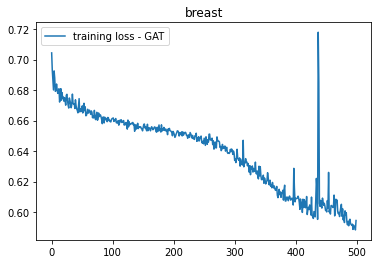

In [8]:
for args in [
    {'model_type': 'GAT', 'num_layers': 2, 'heads': 5, 'batch_size': 32, 'hidden_dim': 8, 'preprocess': 8,'bn':True, 'dropout': 0.25, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 2e-4, 'lr': 0.001},
]:
    args = objectview(args)

# if args.model_type == 'GAT':
#     args.heads = 2
# else:
#     args.heads = 1    

print("Create the "+cancertype+" cancer dataset")    
dataset = create_dataset(dataargs)
print(dataset[0])
print('Train starts...')
t0=time.perf_counter()
train_accs, test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 
t1=time.perf_counter()
print(t1-t0,'s. Training done')
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

## Run test for our best model to save the predictions!
t0=time.perf_counter()
test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=args.model_type)
t1=time.perf_counter()
print()
print(t1-t0,'s. Testing done')
plt.title(cancertype)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.legend()
plt.show()

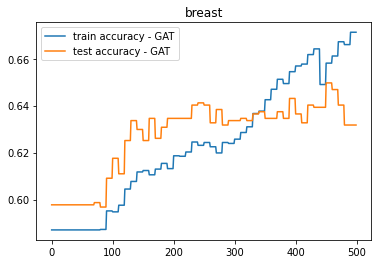

In [9]:
plt.title(cancertype)
plt.plot(train_accs, label="train accuracy" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()

In [10]:
preddf = pd.read_csv('Cancer-Node-' + args.model_type + '_test.csv')

In [11]:
from sklearn.metrics import roc_curve, auc, accuracy_score
pred = preddf.pred.values
label = preddf.label.values
fpr, tpr, thresholds = roc_curve(label, pred, pos_label=1, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
print('auc',roc_auc)
print('acc', accuracy_score(label,pred))

auc 0.6248136528491646
acc 0.6496694995278565


In [12]:
test_accs[-1]

0.6317280453257791

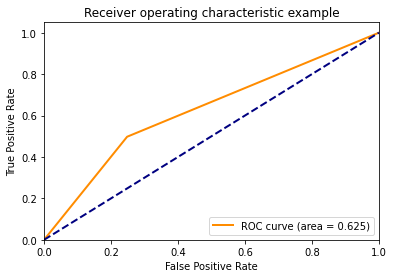

In [13]:
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.3f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

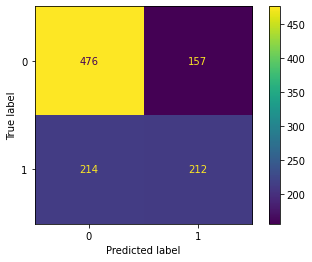

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #RocCurveDisplay
# RocCurveDisplay.from_predictions(label, pred);
cm = confusion_matrix(label, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [15]:
# import torch
# torch.cuda.is_available()

In [16]:
# torch.cuda.device_count()

In [17]:
# torch.cuda.current_device()

In [18]:
# for i in range(3):
#     print(i, torch.cuda.get_device_name(i))

In [19]:
# {'model_type': 'GAT', 'num_layers': 2, 'heads': 5, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.25, 'epochs': 1000, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 2e-4, 'lr': 0.001},
# test auc = 0.65-0.67
# test acc = 0.68